In [1]:
import collections
import csv
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os

%matplotlib inline
%config InlineBackend.figure_format = 'png'

# For recent conferences, I've had HotCRP complain about missing fonts unless I include this line
matplotlib.rcParams['pdf.fonttype'] = 42

In [2]:
def time_to_secs(time_string):
    secs = 0
    tokens = time_string.split(":")
    if len(tokens) == 3:
        hours = int(tokens[0])
        secs += 3600 * hours
        tokens = tokens[1:]
    if len(tokens) == 2:
        minutes = int(tokens[0])
        secs += 60 * minutes
        tokens = tokens[1:]
    assert(len(tokens) == 1)
    secs += float(tokens[0])
    return secs

def micros_empty_to_secs(micros_string):
    if micros_string == "":
        return 0.0
    return float(micros_string) / 1000000

In [3]:
MeasurementTuple = collections.namedtuple("MeasurementTuple", ("ratio",
                                                               "num_major_faults",
                                                               "num_total_faults",
                                                               "user_time",
                                                               "wall_clock_time",
                                                               "pages_evicted",
                                                               "pages_swapped_in",
                                                               "page_fault_time",
                                                               "swap_in_time",
                                                               "evict_time",
                                                               "lock_minpf_time",
                                                               "tpo_pf_time"))

class Measurement(MeasurementTuple):
    @property
    def num_minor_faults(self):
        return self.num_total_faults - self.num_major_faults

class RatioSweep(object):
    def __init__(self, stats_filename, cgroup_filename, ftrace_filename):
        # Maps ratio (100, 90, 80, etc.) to Measurement object describing the stat
        self.by_ratio = {}
        
        # Maps ratio to list of rows
        with open(stats_filename) as sf:
            sr = csv.DictReader(sf)
            stats_by_row = {int(row["RATIO"]) : row for row in sr}
        with open(cgroup_filename) as cf:
            cr = csv.DictReader(cf)
            cgroup_by_row = {int(row["RATIO"]) : row for row in cr}
        with open(ftrace_filename) as ff:
            fr = csv.DictReader(ff)
            ftrace_by_row = {(int(row["RATIO"]), int(row["CPU"])) : row for row in fr}
                
        for ratio in stats_by_row:
            stats = stats_by_row[ratio]
            cgroup = cgroup_by_row[ratio]
            ftrace = ftrace_by_row[(ratio, 0)]
            self.by_ratio[ratio] = Measurement(ratio,
                                               int(cgroup["NUM_MAJOR_FAULTS"]),
                                               int(cgroup["NUM_FAULTS"]),
                                               time_to_secs(stats["USER"]),
                                               time_to_secs(stats["WALLCLOCK"]),
                                               int(stats["PAGES_EVICTED"]),
                                               int(stats["PAGES_SWAPPED_IN"]),
                                               micros_empty_to_secs(ftrace["PAGE_FAULT_TIME"]),
                                               micros_empty_to_secs(ftrace["SWAPIN_TIME"]),
                                               micros_empty_to_secs(ftrace["EVICT_TIME"]),
                                               micros_empty_to_secs(ftrace["LOCK_MINPF_TIME"]) if "LOCK_MINPF_TIME" in ftrace else None,
                                               micros_empty_to_secs(ftrace["3PO_PF_TIME"]) if "3PO_PF_TIME" in ftrace else None)

        
class MultiTrialRatioSweep(object):
    def __init__(self, sweeps, aggregator = None):
        self.num_trials = len(sweeps)
        assert(self.num_trials != 0)
        
        self.by_ratio = {}
        
        ratios = sweeps[0].by_ratio.keys()
        for s in sweeps:
            ratios = ratios & s.by_ratio.keys()

        if aggregator is None:
            aggregator = np.median
        
        for ratio in ratios:
            measures = tuple(s.by_ratio[ratio] for s in sweeps)
            self.by_ratio[ratio] = Measurement(ratio,
                                               aggregator([m.num_major_faults for m in measures]),
                                               aggregator([m.num_total_faults for m in measures]),
                                               aggregator([m.wall_clock_time for m in measures]),
                                               aggregator([m.pages_evicted for m in measures]),
                                               aggregator([m.pages_swapped_in for m in measures]))
            

In [37]:
def parse_ratio_sweep(first_directory, experiment_name, setup, base_directory = ".", trial = None):
    if trial is not None:
        first_directory = "{0}_t{1}".format(first_directory, trial)
    if setup == "linux":
        third_directory = "linux_prefetching_asyncwrites"
    elif setup == "linux_sync":
        third_directory = "linux_prefetching"
    elif setup == "tape":
        third_directory = "tape_prefetching_asyncwrites"
    else:
        raise RuntimeError("Can't handle {0}".format((first_directory, experiment_name, setup)))
    stats_filename = os.path.join(base_directory, first_directory, experiment_name, third_directory, "time_and_swap_results.csv")
    cgroup_filename = os.path.join(base_directory, first_directory, experiment_name, third_directory, "cgroup_results.csv")
    ftrace_filename = os.path.join(base_directory, first_directory, experiment_name, third_directory, "ftrace_results.csv")
    return RatioSweep(stats_filename, cgroup_filename, ftrace_filename)

In [15]:
RATIOS = (5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100)

In [16]:
def smart_round(number):
    if number >= 100:
        return str(int(round(number, 3 - len(str(int(number))))))
    elif number >= 10:
        return "{0:.1f}".format(round(number, 1))
    elif number >= 1:
        return "{0:.2f}".format(round(number, 2))
    elif number >= 0.1:
        return "{0:.3f}".format(round(number, 3))
    elif number >= 0.01:
        return "{0:.4f}".format(round(number, 4))
    elif number >= 0.001:
        return "{0:.5f}".format(round(number, 5))
    else:
        return "negl"

In [ ]:
def plot_breakdown(linux, tape):
    plt.figure(figsize=(6, 3))

    SLICE_RATIO = 20
    linux_m = linux.by_ratio[SLICE_RATIO]
    tape_m = tape.by_ratio[SLICE_RATIO]

    x = (0, 1)

    def get_components(m):
        if m.lock_minpf_time:
            print("MinPF (delayed hits) =", m.lock_minpf_time, ", Total time =", m.wall_clock_time)
            print((m.page_fault_time - m.swap_in_time - m.lock_minpf_time) / m.num_total_faults)
        return (m.user_time,
                m.evict_time,
                m.swap_in_time,
                m.lock_minpf_time or 0,
                m.tpo_pf_time or 0,
                m.page_fault_time - m.swap_in_time - (m.lock_minpf_time or 0) - (m.tpo_pf_time or 0),
                m.wall_clock_time - m.user_time - m.evict_time - m.page_fault_time)

    linux_c = get_components(linux_m)
    tape_c = get_components(tape_m)
    names = ("user time", "evictions", "swapin I/O time", "delayed hit I/O time", "3po pf time", "other pf time", "other")

    total = np.array((0.0, 0.0))
    for items in zip(linux_c, tape_c, names):
        label = items[2]
        arr = np.array(items[:2])
        plt.bar(x, arr, label = label, bottom = total)
        total += arr
        
    plt.ylabel("Runtime (s)")
    plt.xticks(x, ("linux", "tape"))
    
    plt.xlim(-0.5, 3.5)

    plt.legend()
    plt.show()
    
def plot_breakdown_exp(first_directory, exp, base_directory):
    tape_minpf = parse_ratio_sweep(first_directory, exp, "tape", base_directory)
    linux_minpf = parse_ratio_sweep(first_directory, exp, "linux", base_directory)
    plot_breakdown(linux_minpf, tape_minpf)

Styles
---------

In [156]:
np_mmul_style = {"label": "np_matmul", "color": "brown", "marker": "D", "ls": "-"}
mmul_style = {"label": "matmul", "color": "blue", "marker": "s", "ls": "-"}
mmul3_style = {"label": "matmul_3", "color": "black", "marker": "*", "ls": "-"}
mvmul_style = {"label": "mvmul", "color": "green", "marker": "v", "ls": "--"}
dprod_style = {"label": "dprod", "color": "red", "marker": "o", "ls": ":"}
sparse_style = {"label": "spmul", "color": "purple", "marker": "^", "ls": "-."}
np_fft_style = {"label": "np_fft", "color": "pink", "marker": "p", "ls": "-."}

workloads = ["python", "mmult_eigen", "mmult_eigen_par_3", "mmult_eigen_vec", "mmult_eigen_dot", "sparse_eigen", "pyfft"]
styles = [np_mmul_style, mmul_style, mmul3_style, mvmul_style, dprod_style, sparse_style, np_fft_style]
workload_abbrevs = ["np_matmul", "matmul", "matmul_3", "mvmul", "dprod", "spmul", "np_fft"]

core_workloads = ["mmult_eigen", "mmult_eigen_par_3", "mmult_eigen_dot", "sparse_eigen", "pyfft"]
core_styles = [mmul_style, mmul3_style, dprod_style, sparse_style, np_fft_style]
core_workload_abbrevs = ["matmul", "matmul_3", "dprod", "spmul", "np_fft"]

Four-Switch Experiments
=====================

MinPF (delayed hits) = 1.06282 , Total time = 11.09
5.668100875447673e-07
MinPF (delayed hits) = 0.2500671 , Total time = 5.8
1.7220202935780272e-06


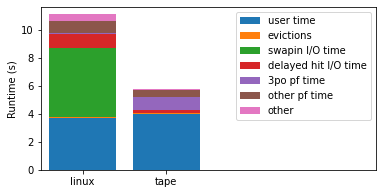

In [157]:
plot_breakdown_exp("experiment_results_10gb_4switch", "mmult_eigen", ".")

MinPF (delayed hits) = 0.061143739999999995 , Total time = 6.28
7.716454974543915e-07
MinPF (delayed hits) = 0.8708632 , Total time = 5.01
1.1515196334445973e-06


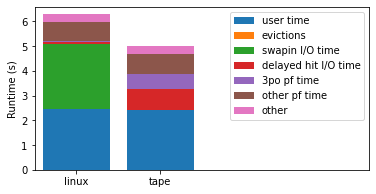

In [158]:
plot_breakdown_exp("experiment_results_10gb_4switch", "mmult_eigen_vec", ".")

MinPF (delayed hits) = 0.01651987 , Total time = 12.35
6.860332238391105e-07
MinPF (delayed hits) = 0.7505896999999999 , Total time = 5.01
1.1955854897521619e-06


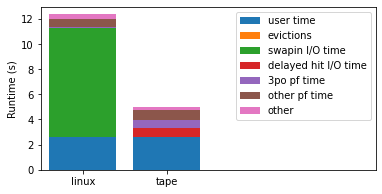

In [159]:
plot_breakdown_exp("experiment_results_10gb_4switch", "mmult_eigen_dot", ".")

MinPF (delayed hits) = 0.4195529 , Total time = 11.99
7.846195112730455e-07
MinPF (delayed hits) = 0.2538923 , Total time = 8.32
1.685838332744081e-06


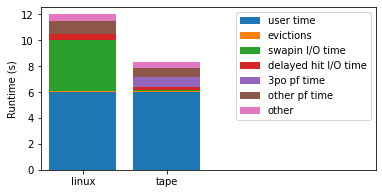

In [160]:
plot_breakdown_exp("experiment_results_10gb_4switch", "sparse_eigen", ".")

MinPF (delayed hits) = 0.7763999 , Total time = 10.82
5.630055919404123e-07
MinPF (delayed hits) = 0.05417555 , Total time = 6.02
1.7181001243346699e-06


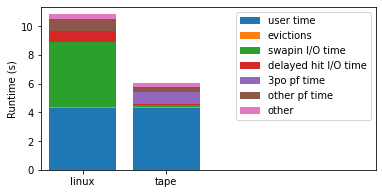

In [161]:
plot_breakdown_exp("experiment_results_10gb_4switch", "python", ".")

MinPF (delayed hits) = 5.239744 , Total time = 79.77
7.362658519492872e-07
MinPF (delayed hits) = 8.246363 , Total time = 35.29
1.4945148067551447e-06


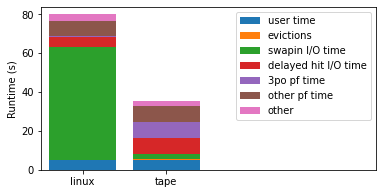

In [162]:
plot_breakdown_exp("experiment_results_10gb_4switch", "pyfft", ".")

Sweep Local Memory Ratio
=======================

In [163]:
def sweep_local_memory(first_directory, workloads, styles, setup):
    plt.figure(figsize = (6, 3))

    for workload, style in zip(workloads, styles):
        sweep = parse_ratio_sweep(first_directory, workload, setup)

        plt.plot(RATIOS, tuple(sweep.by_ratio[r].wall_clock_time / sweep.by_ratio[100].wall_clock_time for r in RATIOS), **style)
        
    plt.legend()
    plt.xlabel("Local Memory Ratio (%)")
    plt.ylabel("Wall-Clock Runtime\nNormalized by Runtime at 100%")
    
    plt.xlim(0, 100)
    plt.ylim(0, 8)

    plt.show()

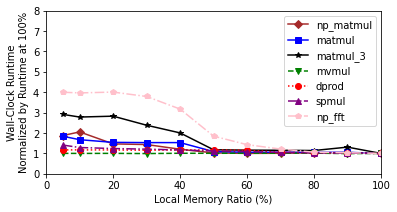

In [164]:
sweep_local_memory("experiment_results_25gb", workloads, styles, "tape")

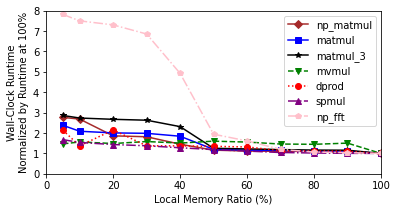

In [165]:
sweep_local_memory("experiment_results_25gb", workloads, styles, "linux")

Comparing Network Setups
=======================

In [149]:
style_25gb = {"label": "25gb", "edgecolor": "black", "color": "blue"}
style_10gb_0switch = {"label": "10gb_0switch", "edgecolor": "black", "color": "lightgreen", "hatch": "//"}
style_10gb_4switch = {"label": "10gb_4switch", "edgecolor": "black", "color": "pink", "hatch": "\\\\"}

networks = ("25gb", "10gb_0switch", "10gb_4switch")
network_styles = (style_25gb, style_10gb_0switch, style_10gb_4switch)

In [182]:
def sweep_network(workloads, workload_abbrevs):
    SLICE_RATIO = 20
    
    plt.figure(figsize = (6, 3))
    
    x = np.arange(len(workloads))
    
    for i, (network, style) in enumerate(zip(networks, network_styles)):
        speedups = []
        first_directory = "experiment_results_{0}".format(network)
        for workload in workloads:
            sweep_tape = parse_ratio_sweep(first_directory, workload, "tape")
            sweep_linux = parse_ratio_sweep(first_directory, workload, "linux")
            speedup = sweep_linux.by_ratio[SLICE_RATIO].wall_clock_time / sweep_tape.by_ratio[SLICE_RATIO].wall_clock_time
            speedups.append(speedup)
        
        width = 0.2
        plt.bar(x - width * ((len(networks) - 1) / 2.0) + width * i, np.array(speedups), width = width, **style)
    
    plt.legend()
    
    plt.ylim(0, 3)
    
    plt.xticks(x, workload_abbrevs)
    
    plt.ylabel("3PO Speedup compared to Linux")
    

    plt.show()

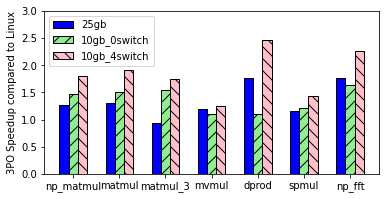

In [184]:
sweep_network(workloads, workload_abbrevs)

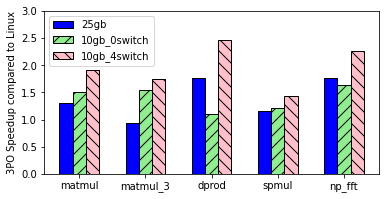

In [185]:
sweep_network(core_workloads, core_workload_abbrevs)

Breakdown
=========